# Displacement vectors search

![Task](pics/task.jpg)

In [1]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
import math
import time
import pandas as pd
%matplotlib inline

In [2]:
circle1 = cv.imread('pics/circle1.png', 0)
circle2 = cv.imread('pics/circle2.png', 0)
square1 = cv.imread('pics/square1.png', 0)
square2 = cv.imread('pics/square2.png', 0)

In [3]:
def sad(a, b):
    return np.sum(np.abs(a.astype(np.float64) - b.astype(np.float64)))

In [4]:
def with_arrows(image, moves, block):
    h, w, _ = moves.shape
    motions = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
    block_half = block // 2
    for x in range(h):
        for y in range(w):
            dx, dy = moves[x, y]
            if dx != 0 or dy != 0:
                start = (y * block + block_half, x * block + block_half)
                end = (y * block + dy + block_half, x * block + dx + block_half)
                cv.arrowedLine(motions, start, end, (255, 0, 0))
    return motions

## Full Search

In [5]:
def full_search(source, shift, block=16, window=32):
    h, w = source.shape
    moves = np.zeros(shape=(h // block, w // block, 2), dtype=np.int64)
    for i in range(0, h - window - block, block) :
        for j in range(0, w - window - block, block) :
            source_block = source[i : i + block, j : j + block]
            s_min, k_min, l_min = -1, 0, 0  
            for k in range(window):
                for l in range(window):
                    shift_block = shift[k + i : k + i + block, l + j : l + j + block]
                    if (shift_block.shape != (16, 16)): print(i, j, k, l)
                    s = sad(source_block, shift_block)
                    if (s < s_min or s_min == -1
                        or s * 0.9 < s_min and k + l < k_min + l_min):
                        s_min, k_min, l_min = s, k, l
            moves[i // block][j // block][0] = k_min
            moves[i // block][j // block][1] = l_min    
    return moves

In [6]:
def full(name, source, shift, block, window):
    start = time.time()
    moves = full_search(source, shift, block, window)
    print(f'Full search for {name}: time = {time.time() - start} s')
    motions = with_arrows(shift, moves, block)
    
    fig, axes = plt.subplots(ncols=2, figsize=(14, 7))
    axes[0].imshow(source, cmap='gray')
    axes[1].imshow(motions)
    fig.tight_layout()
    fig.savefig(f'pics/{name}_full.png')
    plt.show()

Full search for circle: time = 3.0732967853546143 s


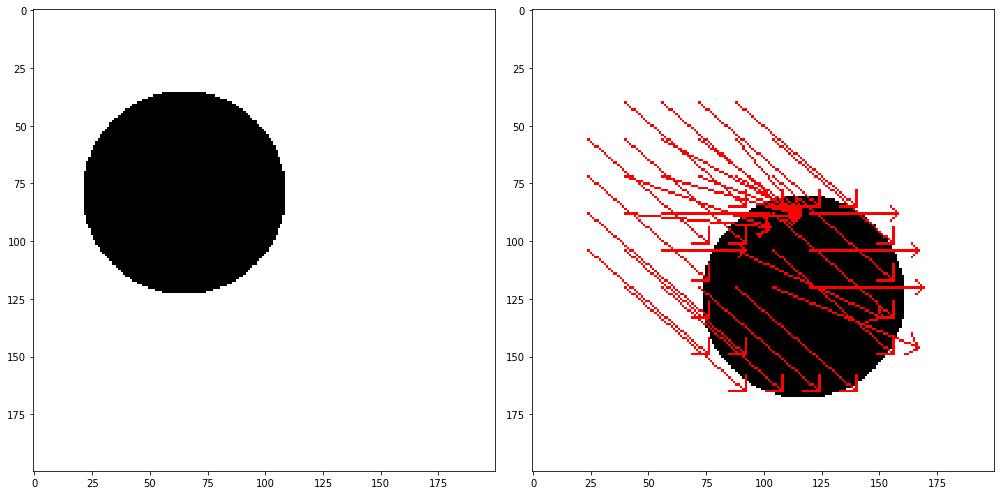

In [7]:
full('circle', circle1, circle2, 16, 64)

Full search for square: time = 5.30285382270813 s


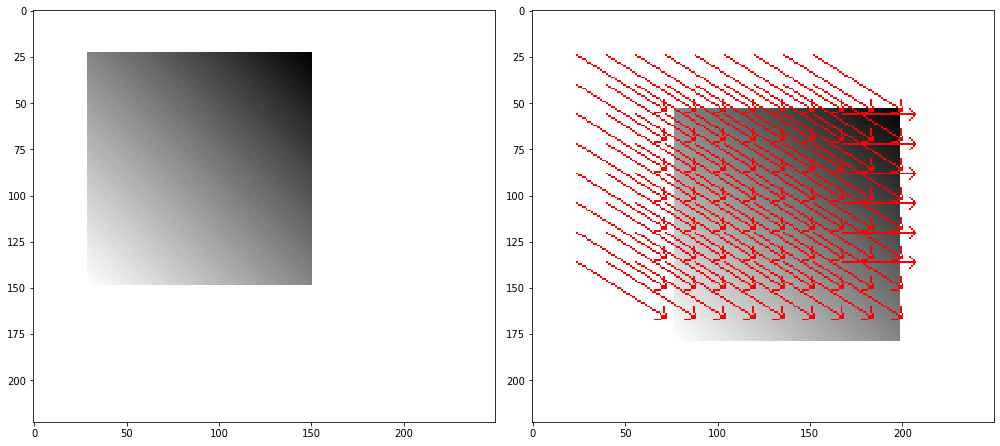

In [8]:
full('square', square1, square2, 16, 64)

## Diamond Search

In [9]:
def diamond_search(source, shift, block=16, window=32):
    def sad_point(source_block, shift, k, l):
        shift_block = shift[k : k + block, l : l + block]
        return sad(source_block, shift_block)

    h, w = source.shape
    window_half = window // 2
    motions = np.zeros(shape=(h // block, w // block, 2), dtype=np.int64)
    diamond_direction_ldsp = [
        [ 0, 0], [ 0, 2], [ 1, 1],
        [ 2, 0], [ 1,-1], [ 0,-2],
        [-1,-1], [-2, 0], [-1, 1]]
    diamond_direction_sdsp = [
        [ 0, 0] ,[ 0, 1] ,[ 1, 0],
        [ 0,-1], [-1, 0], [ 0, 0]]
    
    for i in range(window_half, h - (window_half + block), block):
        for j in range(window_half, w - (window_half + block), block):
            source_block = source[i : i + block, j : j + block]
            sad_space = np.full((window, window), np.inf)
            
            def calculate_dsp(k_center, l_center, diamond_array):
                if (k_center > window_half
                    or k_center < -window_half
                    or l_center > window_half
                    or l_center < -window_half): 
                    return (k_center, l_center)

                sad_local_min = sad_space[k_center, l_center]
                k_local_min = k_center
                l_local_min = l_center
                for (dk, dl) in diamond_array:
                    if sad_space[k_center + dk, l_center + dl] == np.inf:
                        sad_step = sad_point(source_block, shift, k_center + i + dk, l_center + j + dl)
                        sad_space[k_center + dk, l_center + dl] = sad_step
                        if sad_step < sad_local_min:
                            sad_local_min = sad_step
                            k_local_min = k_center + dk
                            l_local_min = l_center + dl
                return (k_local_min, l_local_min)
        
            dk, dl = 0, 0
            while True:
                dk_next, dl_next = calculate_dsp(dk, dl, diamond_direction_ldsp)
                if dk == dk_next and dl == dl_next:
                    break
                dk, dl = dk_next, dl_next
            
            while True:                
                dk_next, dl_next = calculate_dsp(dk, dl, diamond_direction_sdsp)
                if dk == dk_next and dl == dl_next:
                    break
                dk, dl = dk_next, dl_next
                      
            k_min, l_min = dk, dl

            motions[i // block][j // block][0] = k_min
            motions[i // block][j // block][1] = l_min
            
    return motions

In [10]:
def diamond(name, source, shift, block, window):
    start = time.time()
    moves = diamond_search(source, shift, block, window)
    print(f'Diamond search for {name}: time = {time.time() - start} s')
    motions = with_arrows(shift, moves, block)
    
    fig, axes = plt.subplots(ncols=2, figsize=(14, 7))
    axes[0].imshow(source, cmap='gray')
    axes[1].imshow(motions)
    fig.tight_layout()
    fig.savefig(f'pics/{name}_diamond.png')
    plt.show()

Diamond search for circle: time = 0.03908395767211914 s


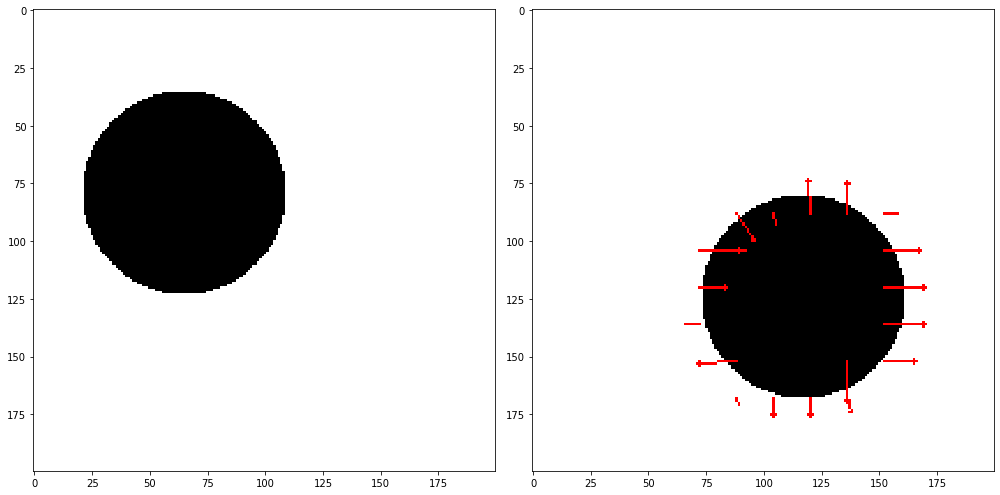

In [11]:
diamond('circle', circle1, circle2, 16, 32)

Diamond search for square: time = 0.0682528018951416 s


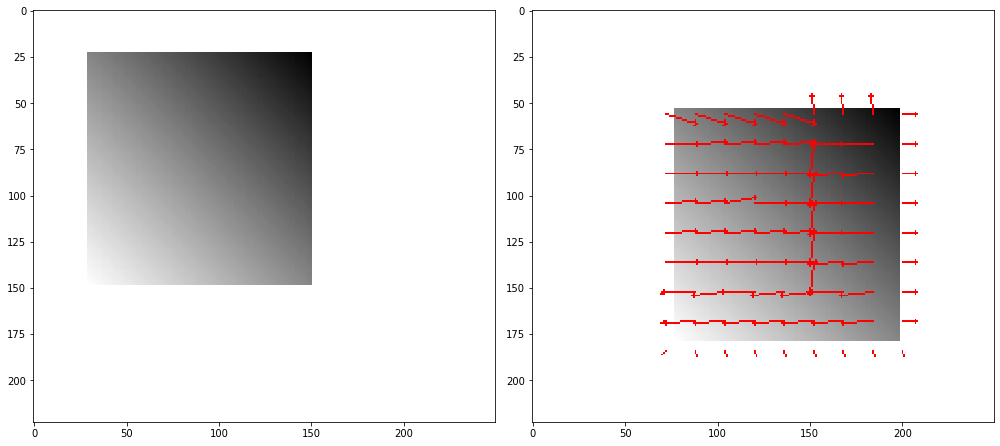

In [12]:
diamond('square', square1, square2, 16, 32)